# Using shared variables (`Data` container adaptation)

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pymc3 as pm

import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az

sns.set_context('notebook')
plt.style.use('seaborn-darkgrid')
print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.6


## The Data class

The [Data](../api/data.rst) container class wraps the theano shared variable class and let the model be aware of its inputs and outputs. This allows one to change the value of a observed variable to predict or refit on new data. All variables of this class must be declared inside a model context and specify a name for them.

Let's see how to declare one inside a simple toy model:

In [2]:
true_mu = 30
observed_data = true_mu + np.random.randn(10)

with pm.Model() as model:
    data = pm.Data('data', observed_data)
    mu = pm.Normal('mu', 0, 10)
    pm.Normal('y', mu=mu, sd=1, observed=data)
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:00<00:00, 6818.53draws/s]


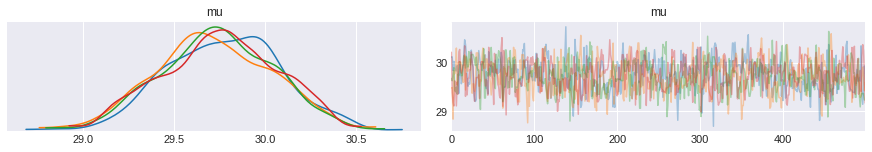

In [3]:
az.plot_trace(trace);

We can get the data container variable from the model using:

In [4]:
model['data'].get_value()

array([30.20693034, 28.41661177, 30.0444191 , 29.17688974, 30.16861776,
       31.04513193, 30.62722024, 28.73661576, 30.81315282, 28.42613378])

Note that we used a [theano SharedVariable method](https://github.com/Theano/theano/blob/d395439aec5a6ddde8ef5c266fd976412a5c5695/theano/compile/sharedvalue.py#L87-L108) to get the value of the variable. This is because our variable is actually a SharedVariable.

We can plot the digraph for our model using:

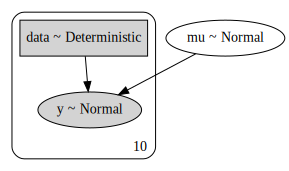

In [5]:
pm.model_to_graphviz(model)

The methods and functions related to the Data container class are:
- `data_container.get_value` (method inherited from the theano SharedVariable): gets the value associated with the `data_container`.
- `data_container.set_value` (method inherited from the theano SharedVariable): sets the value associated with the `data_container`.
- `pm.set_data`: PyMC3 function that sets the value associated with each Data container variable indicated in the dictionary `new_data` with it corresponding new value.

In [6]:
print(pm.set_data.__doc__)

Sets the value of one or more data container variables.

    Parameters
    ----------
    new_data : dict
        New values for the data containers. The keys of the dictionary are
        the  variables names in the model and the values are the objects
        with which to update.
    model : Model (optional if in `with` context)

    Examples
    --------

    .. code:: ipython

        >>> import pymc3 as pm
        >>> with pm.Model() as model:
        ...     x = pm.Data('x', [1., 2., 3.])
        ...     y = pm.Data('y', [1., 2., 3.])
        ...     beta = pm.Normal('beta', 0, 1)
        ...     obs = pm.Normal('obs', x * beta, 1, observed=y)
        ...     trace = pm.sample(1000, tune=1000)

    Set the value of `x` to predict on new data.

    .. code:: ipython
        >>> with model:
        ...     pm.set_data({'x': [5,6,9]})
        ...     y_test = pm.sample_posterior_predictive(trace)
        >>> y_test['obs'].mean(axis=0)
        array([4.6088569 , 5.54128318, 8.32953

## Using Data container variables to fit the same model to several datasets

This and the next section are an adaptation of the notebook ["Advanced usage of Theano in PyMC3"](../Advanced_usage_of_Theano_in_PyMC3.html#using-shared-variables) using `pm.Data`.

We can use Data container variables in PyMC3 to fit the same model to several datasets without the need to recreate the model each time (which can be time consuming if the number of datasets is large):

In [7]:
# We generate 10 datasets
true_mu = [np.random.randn() for _ in range(10)]
observed_data = [mu + np.random.randn(20) for mu in true_mu]

with pm.Model() as model:
    data = pm.Data('data', observed_data[0])
    mu = pm.Normal('mu', 0, 10)
    pm.Normal('y', mu=mu, sd=1, observed=data)

# Generate one trace for each dataset
traces = []
for data_vals in observed_data:
    with model:
        # Switch out the observed dataset
        pm.set_data({'data': data_vals})
        traces.append(pm.sample())

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:00<00:00, 6572.62draws/s]
The acceptance probability does not match the target. It is 0.8864063437691334, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:00<00:00, 6597.53draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:00<00:00, 6666.01draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:00<00:00, 6415.02draws/s]
Auto-assigning NUTS samp

## Using Data container variables to predict on new data

We can also sometimes use Data container variables to work around limitations in the current PyMC3 API. A common task in Machine Learning is to predict values for unseen data, and one way to achieve this is to use a Data container variable for our observations:

In [8]:
x = np.random.randn(100)
y = x > 0

with pm.Model() as model:
    x_shared = pm.Data('x_shared', x)
    coeff = pm.Normal('x', mu=0, sigma=1)
    logistic = pm.math.sigmoid(coeff * x_shared)
    pm.Bernoulli('obs', p=logistic, observed=y)

    # fit the model
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:00<00:00, 6558.29draws/s]


In [9]:
new_values = [-1, 0, 1.]
with model:
    # Switch out the observations and use `sample_posterior_predictive` to predict
    pm.set_data({'x_shared': new_values})
    post_pred = pm.sample_posterior_predictive(trace, samples=500)

100%|██████████| 500/500 [00:00<00:00, 2006.49it/s]


The same concept applied to a more complex model can be seen in the notebook ["Variational Inference: Bayesian Neural Networks"](../notebooks/bayesian_neural_network_advi.html).

## Lenghts (heights) of newborn / toddlers girls as a function of the age (in months)

This example is taken from Osvaldo Martin's book: [Bayesian Analysis with Python: Introduction to statistical modeling and probabilistic programming using PyMC3 and ArviZ, 2nd Edition](https://www.amazon.com/Bayesian-Analysis-Python-Introduction-probabilistic-ebook/dp/B07HHBCR9G).

The World Health Organization and other health institutions around the world collect data
for newborns and toddlers and design [growth charts standards](http://www.who.int/childgrowth/en/). This charts are an essential component of the paediatric toolkit and also as a measure of the general well-being of
populations in order to formulate health and related policies, and plan interventions and
monitor their effectiveness.

An example of such data is the lenghts (heights) of newborn / toddlers girls as a function of
the age (in months):

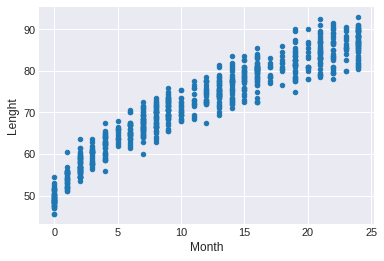

In [10]:
data = pd.read_csv(pm.get_data('babies.csv'))
data.plot.scatter('Month', 'Lenght');

To model this data we are going to use this model:

In [11]:
with pm.Model() as model_babies:
    α = pm.Normal('α', sd=10)
    β = pm.Normal('β', sd=10)
    γ = pm.HalfNormal('γ', sd=10)
    δ = pm.HalfNormal('δ', sd=10)

    month = pm.Data('month', data.Month.values)

    μ = pm.Deterministic('μ', α + β * month**0.5)
    ε = pm.Deterministic('ε', γ + δ * month)
    y_pred = pm.Normal('y_pred', mu=μ, sd=ε, observed=data.Lenght)

    trace_babies = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [δ, γ, β, α]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:03<00:00, 1881.39draws/s]
The acceptance probability does not match the target. It is 0.9069950236660195, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8916113467372374, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8982087356237715, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8929010932282324, but should be close to 0.8. Try to increase the number of tuning steps.


The following figure shows the result of our model. The mean of $\mu$ is represented with a black curve, and two semitransparent orange bands represent 1 and 2 standard deviations.

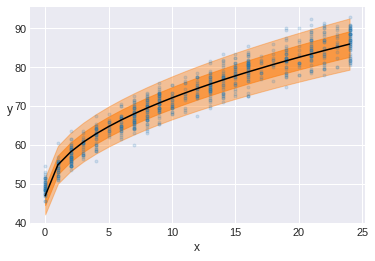

In [12]:
plt.plot(data.Month, data.Lenght, 'C0.', alpha=0.15);
μ_m = trace_babies['μ'].mean(0)
ε_m = trace_babies['ε'].mean(0)
plt.plot(data.Month, μ_m, c='k')
plt.fill_between(data.Month, μ_m + 1 * ε_m, μ_m - 1 * ε_m, alpha=0.6,
color='C1')
plt.fill_between(data.Month, μ_m + 2 * ε_m, μ_m - 2 * ε_m, alpha=0.4,
color='C1')
plt.xlabel('x')
plt.ylabel('y', rotation=0);

At the moment of writing Osvaldo's daughter has two weeks ($\approx 0.5$ months), and thus he wonders how her lenght compares to the growth chart we have just created. One way to answer this question is to ask the model for the distribution of the variable length for babies of 0.5 months. Using PyMC3 we can ask this questions with the function sample_ppc , as this will return samples of conditioned on the obseved data and the estimated distribution of parameters, that is including uncertainties. The only problem is that by default this function will return predictions for for the observed values of , and $0.5$ months (the value he cares) has not been observed, all measures are reported for integer months. The easier way to get predictions for non-observed values of is to define a Data container variable (as part of the model) and then update the value of the variable right before sampling from the posterior predictve distribution.

In [13]:
with model_babies:
    pm.set_data({'month': [0.5]})
    y_ppc = pm.sample_ppc(trace_babies, 2000)

y_ppc = y_ppc['y_pred'][:,0]

/home/juan/anaconda3/envs/dev_pymc3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████| 2000/2000 [00:00<00:00, 2287.28it/s]


Now we can plot the expected distribution of lenghts for babies with 2 weeks old and compute additional quantities for example the percentile of a child given her length:

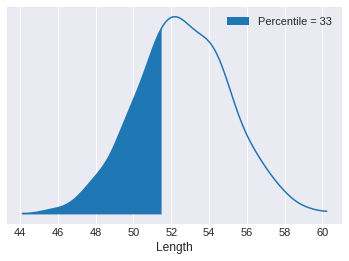

In [14]:
ref = 51.5
density, l, u = az.plots._fast_kde(y_ppc)
x_ = np.linspace(l, u, 200)
plt.plot(x_, density)
percentile = int(sum(y_ppc <= ref) / len(y_ppc) * 100)
plt.fill_between(x_[x_ < ref], density[x_ < ref], label='Percentile = {:2d}'.format(percentile))
plt.xlabel('Length')
plt.yticks([])
plt.legend();